<a href="https://colab.research.google.com/github/premgolani/Decision-Tree-Through-Spark/blob/master/Brain_Tumor_Detection_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Detection Using CNN

> About Dataset: The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Modules

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
from keras.models import Sequential
%matplotlib inline
import os

### Data Preparation & Preprocessing

In [3]:
!git clone https://github.com/MuhamedAhmed11/Brain-Tumor-Detection.git

Cloning into 'Brain-Tumor-Detection'...
remote: Enumerating objects: 2306, done.
remote: Counting objects: 100% (2306/2306), done.
remote: Compressing objects: 100% (2303/2303), done.
remote: Total 2306 (delta 3), reused 2303 (delta 2), pack-reused 0
Receiving objects: 100% (2306/2306), 39.90 MiB | 30.47 MiB/s, done.
Resolving deltas: 100% (3/3), done.


### Data Augmentation
Since this is a small dataset, There wasn't enough examples to train the neural network. Also, data augmentation was useful in taclking the data imbalance issue in the data.

Before data augmentation, the dataset consisted of:
155 positive and 98 negative examples, resulting in 253 example images.

After data augmentation, now the dataset consists of:
1085 positive and 980 examples, resulting in 2065 example images.

Note: these 2065 examples contains also the 253 original images. They are found in folder named 'augmented data'.

In [4]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    """
    Arguments:
        file_dir: A string representing the directory where images that we want to augment are found.
        n_generated_samples: A string representing the number of generated samples using the given image.
        save_to_dir: A string representing the directory in which the generated images will be saved.
    """

    #from keras.preprocessing.image import ImageDataGenerator
    #from os import listdir

    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest'
                                 )


    for filename in listdir(file_dir):
        # load the image
        image = cv2.imread(file_dir + '\\' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following:

1. Read the image.
2. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
3. Apply normalization because we want pixel values to be scaled to the range 0-1.
4. Append the image to X and its label to y.

After that, Shuffle X and y, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).
Finally, Return X and y.

In [6]:
augmented_path = 'Brain-Tumor-Detection/augmented data/'

In [7]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them.
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            # image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [8]:
# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2075
X shape is: (2075, 240, 240, 3)
y shape is: (2075, 1)


##### Conclusion:
> As we see, we have 2065 images. Each images has a shape of (240, 240, 3)

### Splitting Data
> Split X and y into training, validation and validation sets

In [9]:
def split_data(X, y, test_size=0.2):
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size, shuffle=True)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, shuffle=True)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [11]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1452
number of development examples = 312
number of test examples = 311
X_train shape: (1452, 240, 240, 3)
Y_train shape: (1452, 1)
X_val (dev) shape: (312, 240, 240, 3)
Y_val (dev) shape: (312, 1)
X_test shape: (311, 240, 240, 3)
Y_test shape: (311, 1)


In [12]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    score = f1_score(y_true, y_pred)

    return score

### Plot sample images

In [13]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

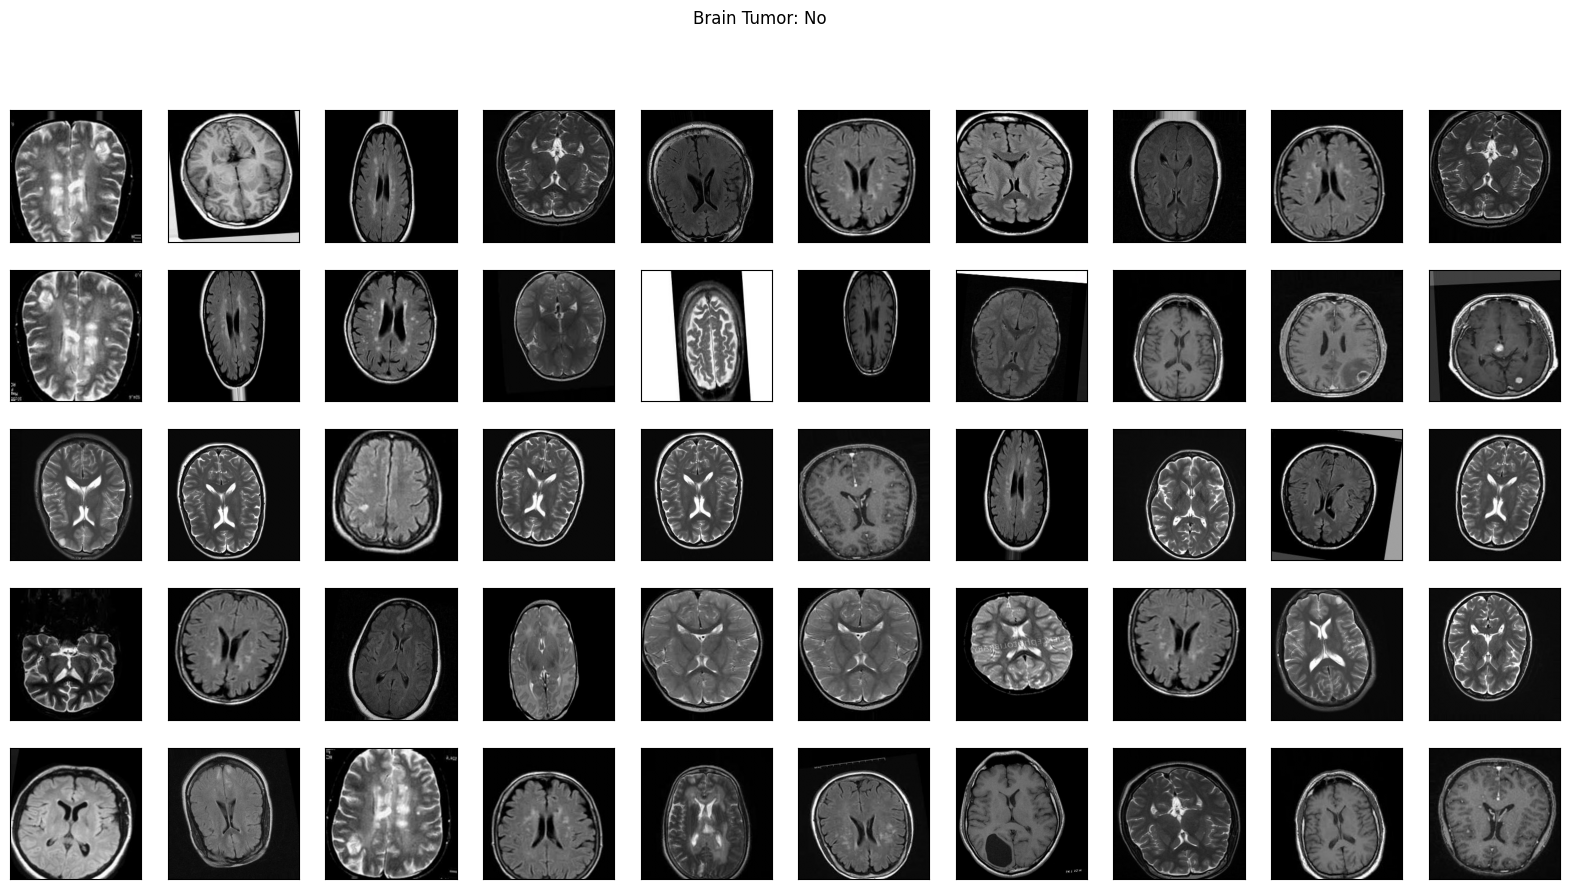

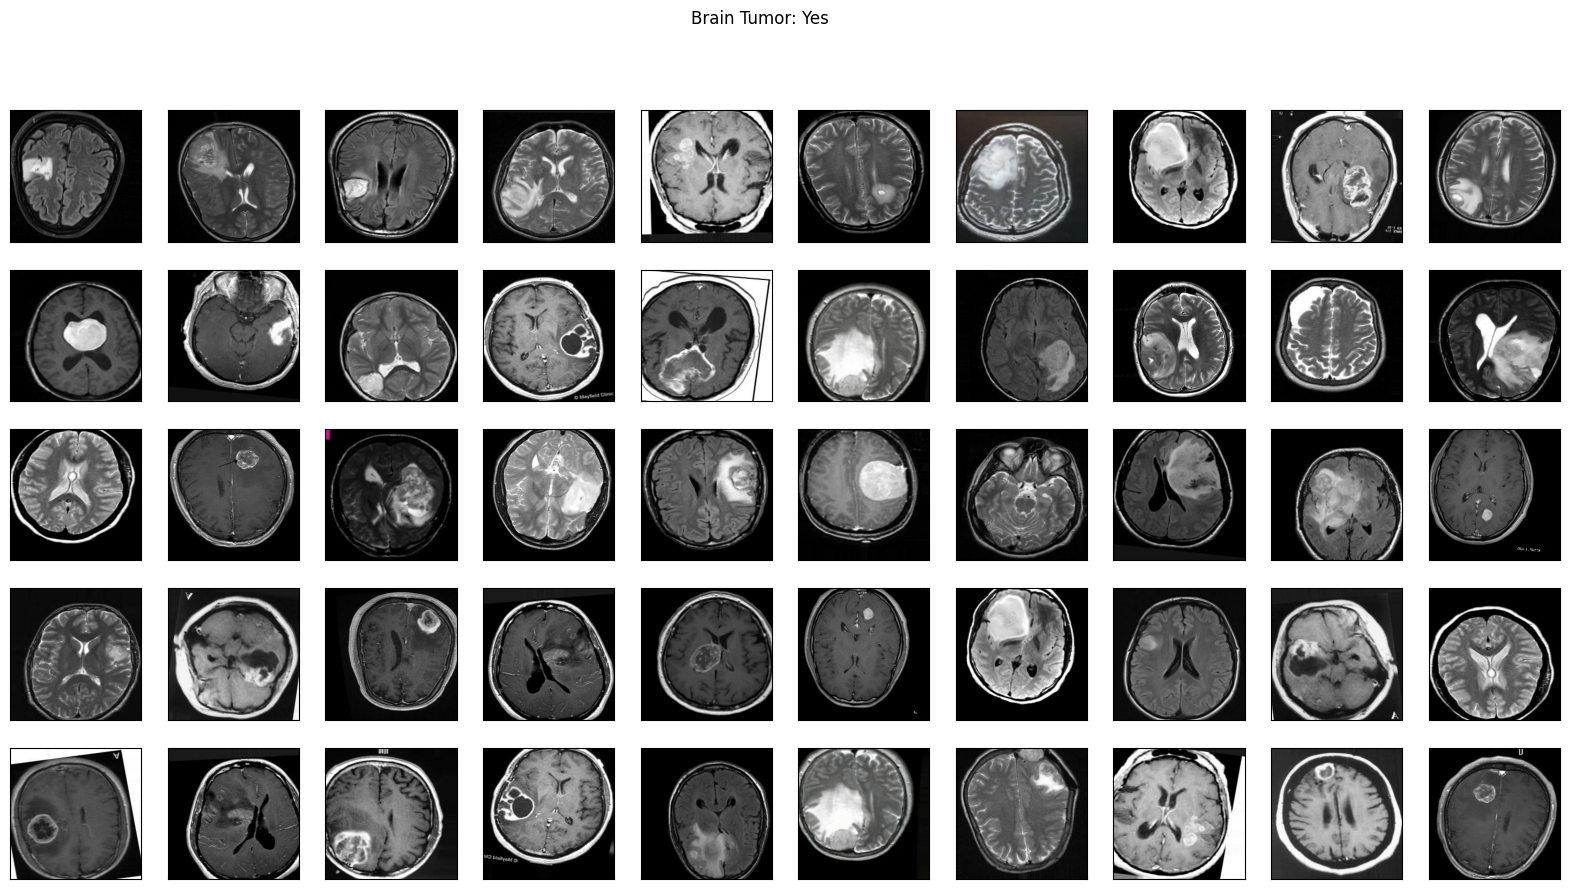

In [14]:
plot_sample_images(X, y)

### Build CNN Model

In [15]:
model = Sequential()
model.add(Conv2D(64,(3,3), input_shape=(240, 240, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

#### Compile the Model

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### Train the Model

In [17]:
model.fit(x=X_train, y=y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
23/23 [==============================] - 28s 478ms/step - loss: 1.0530 - accuracy: 0.5944 - val_loss: 0.5346 - val_accuracy: 0.7147
Epoch 2/20
23/23 [==============================] - 5s 240ms/step - loss: 0.6056 - accuracy: 0.6722 - val_loss: 0.5165 - val_accuracy: 0.7308
Epoch 3/20
23/23 [==============================] - 5s 226ms/step - loss: 0.5455 - accuracy: 0.7445 - val_loss: 0.4843 - val_accuracy: 0.7917
Epoch 4/20
23/23 [==============================] - 6s 245ms/step - loss: 0.5102 - accuracy: 0.7555 - val_loss: 0.5011 - val_accuracy: 0.7692
Epoch 5/20
23/23 [==============================] - 5s 227ms/step - loss: 0.4637 - accuracy: 0.7934 - val_loss: 0.4988 - val_accuracy: 0.7853
Epoch 6/20
23/23 [==============================] - 5s 234ms/step - loss: 0.4209 - accuracy: 0.8037 - val_loss: 0.4724 - val_accuracy: 0.7949
Epoch 7/20
23/23 [==============================] - 5s 230ms/step - loss: 0.3723 - accuracy: 0.8416 - val_loss: 0.4882 - val_accuracy: 0.7788
Epoch

#### Evaluate the Model

In [18]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 2s 127ms/step - loss: 1.2255 - accuracy: 0.7781


[1.2254701852798462, 0.7781350612640381]

In [19]:
y_pred = model.predict(X_test)
f1score = compute_f1_score(y_test, y_pred)
print(f"F1 score: {f1score}")

10/10 [==============================] - 0s 36ms/step
F1 score: 0.8034188034188035


### Data Summary

In [20]:
def summary():
    yes = augmented_path + 'yes/'
    no = augmented_path + 'no/'

    nyes=len(os.listdir(yes))
    nno=len(os.listdir(no))
    ntotal=nyes+nno

    print('Total Images : ', ntotal)
    print('Yes Images : {} ( {}% )'.format(nyes, np.round((nyes/ntotal*1.0)*100), 3))
    print('No Images : {} ( {}% )'.format(nno, np.round((nno/ntotal*1.0)*100), 3))

In [21]:
summary()

Total Images :  2075
Yes Images : 1095 ( 53.0% )
No Images : 980 ( 47.0% )


### Saving Model & its data to the Drive

In [23]:
model.save("/content/Brain-Tumor-Detection/BrainTumorProject/83.60")

In [24]:
np.save('/content/Brain-Tumor-Detection/BrainTumorProject/X_train', X_train, allow_pickle=False,fix_imports=False)
np.save('/content/Brain-Tumor-Detection/BrainTumorProject/X_test', X_test, allow_pickle=False,fix_imports=False)
np.save('/content/Brain-Tumor-Detection/BrainTumorProject/Y_train', y_train, allow_pickle=False,fix_imports=False)
np.save('/content/Brain-Tumor-Detection/BrainTumorProject/Y_test', y_test, allow_pickle=False,fix_imports=False)
np.save('/content/Brain-Tumor-Detection/BrainTumorProject/X_val', X_val, allow_pickle=False,fix_imports=False)
np.save('/content/Brain-Tumor-Detection/BrainTumorProject/Y_val', y_val, allow_pickle=False,fix_imports=False)

## Conclusion:
Now, the model detects brain tumor with:

83.6% accuracy on the test set.

85.87% f1 score on the test set.

These resutls are very good considering that the data is balanced.

In [25]:
history = model.history.history

In [27]:
for key in history.keys():
    print(key)

In [28]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [29]:
plot_metrics(history)

KeyError: ignored

In [32]:
# Part 4 - Making a single prediction test
import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('/content/Brain-Tumor-Detection/augmented data/no/aug_1 no._0_1102.jpg', target_size = (240,240))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
result

1/1 [==============================] - 0s 22ms/step


array([[5.657892e-05]], dtype=float32)

In [33]:
if result[0]<=0.5:
    print("No BrainTumor")
else:
    print("BrainTumor")

No BrainTumor


In [34]:
#save model
from tensorflow.keras.models import load_model
model.save('/content/Brain-Tumor-Detection/brain_tumor.h5')

Brain-Tumor-Detection/  drive/  sample_data/


In [43]:
mkdir js

In [40]:
cd static

/content/Brain-Tumor-Detection/static


In [48]:
run app.py

 * Serving Flask app 'app'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


<Figure size 640x480 with 0 Axes>